In [599]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

## Load the dataset

In [600]:
mnist = np.load("./mnist.npz")

In [601]:
(x_test, y_test), (x_train, y_train) = (mnist['x_test'], mnist['y_test']), (mnist['x_train'], mnist['y_train'])

5


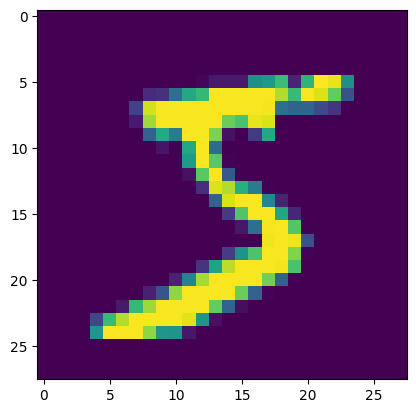

In [602]:
print(y_train[0])
plt.imshow(x_train[0])

## Setup the classifier

Very micrograd inspired, but working on tensors instead of the scalars. Using numpy to go faster

In [694]:
class Tensor:
  def __init__(self, data, _prev = (), _op='', _npseed=1773):
    if not hasattr(data, "__len__"): data = [data] # for simplicity storing everything as matrices
    self.data = data if isinstance(data, np.ndarray) and len(data.shape) == 2 else np.atleast_2d(np.asarray(data))
    self._shape = np.shape(self.data)
    assert len(self._shape) == 2, f"shape doesn't seem to be 2D, got {self._shape}"
    # autograd bits
    self.grad = self._zero_grad()
    self._backward = lambda: None
    self._prev = set(_prev)
    self._op = _op

  # the backpropogator
  def backward(self):
    assert self._shape == (1,1), f"backward() can only be called on a scalar tensor, got shape: {self._shape}"

    # build the topo order of all the previous tensors
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # Set own gradient to 1
    self.grad = self._ones_grad()
    # go through the vars and calcualte the grad
    for v in reversed(topo):
      v._backward()

  # Vector/matrix ops
  def dot(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(np.matmul(self.data, other.data), (self, other), 'dot')
    def _backward():
      self.grad += np.matmul(out.grad, other.data.T)
      other.grad += np.matmul(self.data.T, out.grad)
    out._backward = _backward
    return out

  def T(self):
    out = Tensor(self.data.T, (self,), 'T')
    def _backward():
      self.grad = out.grad.T
    self._backward = _backward
    return out

  # element-wise ops (broadcasted for arrays)
  def __add__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(np.add(self.data, other.data), (self, other), '+')

    def _backward():
      self.grad += out._val_grad(out.grad)
      other.grad += out._val_grad(out.grad)
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)
    out = Tensor(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += self._val_grad(out.grad) * other.data
      other.grad += self._val_grad(out.grad) * self.data
    out._backward = _backward

    return out

  def __pow__(self, exponent):
    assert isinstance(exponent, (float, int)), "power implemented only for float and int exponents"

    out = Tensor(self.data ** exponent, (self,), f'**{exponent}')

    def _backward():
      self.grad += (exponent * self.data**(exponent - 1)) * out.grad
    self._backward = _backward

    return out
    
  # Activation functions
  def relu(self):
    data = self.data
    data[data<0] = 0
    out = Tensor(data, (self,), 'ReLU')

    def _backward():
      pass
    out._backward = _backward

    return out

  def softmax(self):
    assert len(self._shape) == 1, f"softmax defined for vectors, got shape {self._shape}"
    out = self.exp()
    raise NotImplementedError


  # generation helpers
  def uniform(shape, low=-1, high=1):
    assert len(shape) == 2, f"matricies only!, got shape: {shape}"
    return Tensor((high - low) * np.random.rand(*shape) + low)

  # free real estate
  def __rmul__(self, other): return  self * other
  def __sub__(self, other): return  self + (-other)
  def __rsub__(self, other): return  (-self) + other
  def __radd__(self, other): return self + other
  def __neg__(self): return self * -1
  def __truediv__(self, other): return self * other**-1
  def __rtruediv__(self, other): return other * self**-1

  # internal grad helpers
  def _zero_grad(self): return np.zeros(self._shape)
  def _ones_grad(self): return np.ones(self._shape)
  def _val_grad(self, val): return np.ones(self._shape) * val

  # internal rand helpers
  #def _rand(shape): return np.random.rand(*shape)

  # formatter for pretty printing
  def __repr__(self): return f'Tensor(shape={self._shape}, grad={self.grad}, _op={self._op},\n{self.data}\n)\n'

In [695]:
class Test():
  def __init__(self):
    self.L1 = Tensor(2)
    self.L1b = Tensor(10)
  def forward(self, x):
    return x.dot(self.L1) + self.L1b

t = Test()

In [696]:
out = t.forward(Tensor(8))
print(out)
out.backward()
t.L1.grad


Tensor(shape=(1, 1), grad=[[0.]], _op=+,
[[26]]
)



array([[8.]])

In [699]:
# Generate two categories of x,y data
x1 = np.random.default_rng().normal(10, 1, size=(1000,2))
x2 = np.random.default_rng().normal(2, 1, size=(1000,2))


In [700]:
# super-simple net for testing
class twobinnet:
    def __init__(self):
      self.L1 = Tensor.uniform((2,2))
      self.L1b = Tensor.uniform((1,2))
      self.L2 = Tensor.uniform((2,1))
      self.L2b = Tensor.uniform((1,1))
    def forward(self, x):
      out = x.dot(self.L1)
      out = out + self.L1b
      out = out.dot(self.L2)
      out = out + self.L2b
      # out = out.softmax()
      return out
    
lol = twobinnet()
out = lol.forward(Tensor(x1[1]))

out.backward()

print(out)
lol.L1.grad


Tensor(shape=(1, 1), grad=[[1.]], _op=+,
[[-6.71223386]]
)



array([[8.80517106, 4.6088053 ],
       [8.315237  , 4.35236386]])

In [720]:
# hello, world: mnist classifier with two hidden layers
np.random.seed(1337)
class Shittynet():
  def __init__(self):

    self.L1 = Tensor.uniform((28*28, 10))
    self.L1b = Tensor.uniform((1,10))

    self.L2 = Tensor.uniform((10,10))
    self.L2b = Tensor.uniform((1,10))
  
  def forward(self, x):
    out = x.dot(self.L1) + self.L1b
    out = out.relu()
    print(out)
    out = out.dot(self.L2) + self.L2b
    out = out.softmax()
    return out




In [721]:
lol = Shittynet()
data = x_train[0].flatten()
data = data / np.linalg.norm(data)

out = lol.forward(Tensor(data))
loss = out.forward(Tensor(data)) - [0., 0., 0., 0.,]
out.backward()

Tensor(shape=(1, 10), grad=[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], _op=ReLU,
[[0.42279917 0.         0.35129242 0.         0.51479277 0.31507469
  1.30629339 0.         0.24305745 0.        ]]
)



AssertionError: softmax defined for vectors, got shape (1, 10)